In [1]:
##########################################
# General helper functions and libraries #
##########################################

# General data libs
import pandas as pd
import numpy as np

# General plotting libs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation
import plotly.express as px
import seaborn as sns

####################
# Modeling process #
####################

# Networks
import networkx as nx
from pyvis.network import Network
from community import community_louvain

In [2]:
# Based on: https://www.bis.org/statistics/r_qa1406_hanx9b.pdf
# Originally from "Consolidated Banking Statistics, Updated 27 July 2023" described at: https://www.bis.org/statistics/consstats.htm
# Full set here: https://www.bis.org/statistics/full_data_sets.htm
# Retrieved on 13 Oct

# File, will take ~15sec to load
df = pd.DataFrame(pd.read_csv('https://storage.googleapis.com/suptech-lab-practical-data-science-public/WS_CBS_PUB_csv_col.csv'))
df.shape

(174575, 151)

In [3]:
df.columns

Index(['FREQ', 'Frequency', 'L_MEASURE', 'Measure', 'L_REP_CTY',
       'Reporting country', 'CBS_BANK_TYPE', 'CBS bank type', 'CBS_BASIS',
       'CBS reporting basis',
       ...
       '2020-Q4', '2021-Q1', '2021-Q2', '2021-Q3', '2021-Q4', '2022-Q1',
       '2022-Q2', '2022-Q3', '2022-Q4', '2023-Q1'],
      dtype='object', length=151)

In [4]:
# Immediate borrower basis
set(df['CBS reporting basis'])

{'Guarantor basis',
 'Immediate counterparty basis',
 'Net risk transfers (Inward-Outward)',
 'Outward risk transfers'}

In [5]:
# Amounts outstanding
set(df['Measure'])

{'Amounts outstanding / Stocks'}

In [6]:
set(df['Remaining maturity'])

{'Over 1 year and up to and including 2 years',
 'Over 2 years',
 'Total (all maturities)',
 'Up to and including 1 year'}

In [7]:
# List the columns we want to keep
cols = [
  'Reporting country',
  'Counterparty country',
  '2013-Q4',
  '2014-Q4',
  '2015-Q4',
  '2016-Q4',
  '2017-Q4'
]

# 1. Make a copy of the original dataframe
# 2. Filter only for the rows we want
# 3. Keep only the columns we want
df1 = df.copy(deep=True)
df1 = df1[(df1['CBS bank type']=="Domestic banks")
      & (df1['CBS reporting basis']=="Immediate counterparty basis")
      & (df1['Balance sheet position']=="Total claims")
      & (df1['Remaining maturity']=="Total (all maturities)")]
df1 = df1[cols]

# Drop the rows containing global aggregates
df1 = df1[(df1['Reporting country']!="All reporting countries") & (df1['Counterparty country']!="All reporting countries") &
         (df1['Counterparty country']!='All countries (total)') & (df1['Counterparty country']!='All countries excluding residents') &
         (df1['Counterparty country']!='International organisations') & (df1['Counterparty country']!='International organisations') &
         (df1['Counterparty country']!='Residents/Local') & (df1['Counterparty country']!='Residents/Local') &
         (df1['Counterparty country']!='Euro area') & (df1['Counterparty country']!='Euro area')]

# Only those who have recorded financial data for the quarter we're looking at
df1 = df1[pd.notnull(df1['2013-Q4'])]

df1


,Reporting country,Counterparty country,2013-Q4,2014-Q4,2015-Q4,2016-Q4,2017-Q4
113,Australia,Chad,0.008,0.741,0.301,NaN,NaN
172,Switzerland,Chad,2.028,18.635,0.212,0.021,0.013
234,France,Chad,383.000,662.000,525.000,465.000,491.000
424,United States,Chad,35.000,46.000,44.000,38.000,39.000
513,Austria,Germany,39068.469,37377.994,37690.878,35869.525,42703.591
...,...,...,...,...,...,...,...
174270,Denmark,Djibouti,1.000,1.000,1.000,1.000,1.000
174303,France,Djibouti,30.000,58.000,10.000,14.000,12.000
174335,United Kingdom,Djibouti,21.000,17.000,12.000,6.000,NaN
174490,Sweden,Djibouti,18.168,15.395,7.716,1.542,0.351


In [8]:
set(df1['Reporting country'])

{'Australia',
 'Austria',
 'Belgium',
 'Brazil',
 'Canada',
 'Chile',
 'Chinese Taipei',
 'Denmark',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Ireland',
 'Italy',
 'Japan',
 'Korea',
 'Mexico',
 'Netherlands',
 'Panama',
 'Portugal',
 'Spain',
 'Sweden',
 'Switzerland',
 'Türkiye',
 'United Kingdom',
 'United States'}

In [9]:
# Add nodes
G = nx.from_pandas_edgelist(df1, 'Reporting country', 'Counterparty country', edge_attr=True, create_using=nx.DiGraph)
print("Nodes:", len(G.nodes()), "Edges:", len(G.edges()))

Nodes: 215 Edges: 2674


In [10]:
G['Spain']['Sweden']

{'2013-Q4': 2860.0,
 '2014-Q4': nan,
 '2015-Q4': nan,
 '2016-Q4': nan,
 '2017-Q4': 5846.555}

In [11]:
G['Sweden']['Spain']

{'2013-Q4': 3769.417,
 '2014-Q4': 2791.913,
 '2015-Q4': 2123.155,
 '2016-Q4': 1997.348,
 '2017-Q4': 1801.602}

In [12]:
short_countries = ['Australia',
                'Austria',
                'Belgium',
                'Brazil',
                'Canada',
                'Chile',
                'Chinese Taipei',
                'Denmark',
                'France',
                'Germany',
                'Greece',
                'Ireland',
                'Italy',
                'Japan',
                'Korea',
                'Mexico',
                'Netherlands',
                'Panama',
                'Portugal',
                'Spain',
                'Sweden',
                'Switzerland',
                'Türkiye',
                'United Kingdom',
                'United States']

df2 = df1[(df1['Reporting country'].isin(short_countries)) & (df1['Counterparty country'].isin(short_countries)) & (df1['Reporting country'] != df1['Counterparty country'])]
G2 = nx.from_pandas_edgelist(df2, 'Reporting country', 'Counterparty country', edge_attr=True, create_using=nx.DiGraph)

In [13]:
list(nx.connected_components(G.to_undirected()))

[{'Afghanistan',
  'Albania',
  'Algeria',
  'Andorra',
  'Angola',
  'Argentina',
  'Armenia',
  'Aruba',
  'Australia',
  'Austria',
  'Azerbaijan',
  'Bahamas',
  'Bahrain',
  'Bangladesh',
  'Barbados',
  'Belarus',
  'Belgium',
  'Belize',
  'Benin',
  'Bermuda',
  'Bhutan',
  'Bolivia',
  'Bonaire, Sint Eustatius and Saba',
  'Bosnia and Herzegovina',
  'Botswana',
  'Brazil',
  'Brunei',
  'Bulgaria',
  'Burkina Faso',
  'Burundi',
  'Cambodia',
  'Cameroon',
  'Canada',
  'Cape Verde',
  'Cayman Islands',
  'Central African Republic',
  'Chad',
  'Chile',
  'China',
  'Chinese Taipei',
  'Colombia',
  'Comoros',
  'Congo',
  'Congo Democratic Republic',
  'Costa Rica',
  "Cote d'Ivoire",
  'Croatia',
  'Cuba',
  'Curacao',
  'Cyprus',
  'Czechia',
  'Denmark',
  'Djibouti',
  'Dominica',
  'Dominican Republic',
  'Ecuador',
  'Egypt',
  'El Salvador',
  'Equatorial Guinea',
  'Eritrea',
  'Estonia',
  'Eswatini',
  'Ethiopia',
  'Faeroe Islands',
  'Falkland Islands',
  'Fiji',

In [14]:
list(nx.strongly_connected_components(G))

[{'Chad'},
 {'Saudi Arabia'},
 {'Luxembourg'},
 {'India'},
 {'Egypt'},
 {'Jordan'},
 {'Venezuela'},
 {'Bosnia and Herzegovina'},
 {'Barbados'},
 {'Uganda'},
 {'Estonia'},
 {'Malta'},
 {'North Korea'},
 {'Sudan'},
 {'Hong Kong SAR'},
 {'Mauritius'},
 {'Central African Republic'},
 {'Maldives'},
 {'Seychelles'},
 {'Malaysia'},
 {'Qatar'},
 {'United Arab Emirates'},
 {'Israel'},
 {'Congo Democratic Republic'},
 {'Honduras'},
 {'Mozambique'},
 {'Guernsey'},
 {'Bangladesh'},
 {'Kuwait'},
 {'Gibraltar'},
 {'Latvia'},
 {'Georgia'},
 {'Iran'},
 {'Lithuania'},
 {'Liberia'},
 {'Hungary'},
 {'Turks and Caicos Islands'},
 {'Malawi'},
 {'Togo'},
 {'Burkina Faso'},
 {'Jamaica'},
 {'Equatorial Guinea'},
 {'Zambia'},
 {'Gambia'},
 {'Burundi'},
 {'Dominica'},
 {'Yemen'},
 {'Belarus'},
 {'Syria'},
 {'Guatemala'},
 {'Czechia'},
 {'Rwanda'},
 {'Zimbabwe'},
 {'Cayman Islands'},
 {'Kazakhstan'},
 {'Benin'},
 {'Mali'},
 {'Comoros'},
 {'Myanmar'},
 {'Peru'},
 {'San Marino'},
 {'Namibia'},
 {'Croatia'},
 {'Bel

{'whiskers': [<matplotlib.lines.Line2D at 0x1e71e0ec750>,
 'caps': [<matplotlib.lines.Line2D at 0x1e71e097a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e71e0efa90>],
 'medians': [<matplotlib.lines.Line2D at 0x1e71e094e50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e71e096f90>],
 'means': []}

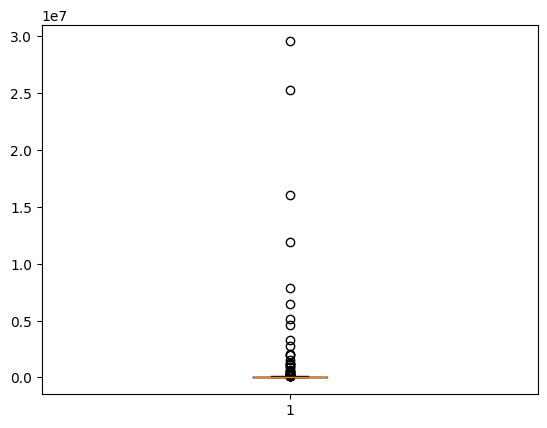

In [15]:
degree_values = [v for k, v in G.degree(weight='2013-Q4')]
fig = plt.figure();
plt.boxplot(degree_values)

In [16]:
Din = nx.in_degree_centrality(G)
Dout = nx.out_degree_centrality(G)
CC = nx.closeness_centrality(G.reverse())  #reverse edges to match networx convention
BC = nx.betweenness_centrality(G.to_undirected())
EC = nx.eigenvector_centrality(G.reverse())  #reverse edges to match networx convention

In [17]:
#For plotting, we combine all the centrality dictionaries into a dataframe
dictionary_list = []
for country in Din.keys():
    row = {'country':country,
          'in_degree_centrality':Din[country],
          'out_degree_centrality':Dout[country],
          'closeness_centrality':CC[country],
          'betweenness_centrality':BC[country],
          'eigenvector_centrality':EC[country]}
    dictionary_list.append(row)
df_centrality = pd.DataFrame(dictionary_list)

df_centrality.sort_values(by = ['out_degree_centrality'],ascending = False).head()

,country,in_degree_centrality,out_degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality
2,Switzerland,0.116822,0.948598,0.946903,0.156384,0.218025
3,France,0.121495,0.887850,0.895397,0.112950,0.218025
13,United Kingdom,0.116822,0.855140,0.873469,0.099170,0.208945
0,Australia,0.107477,0.817757,0.845850,0.111580,0.208945
4,United States,0.121495,0.813084,0.839216,0.084956,0.218025


C:\Users\gilan\AppData\Local\Temp\ipykernel_16404\3342247016.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)  #rotate axis tick labels 90 degrees
C:\Users\gilan\AppData\Local\Temp\ipykernel_16404\3342247016.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)  #rotate axis tick labels 90 degrees
C:\Users\gilan\AppData\Local\Temp\ipykernel_16404\3342247016.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)  #rotate axis tick labels 90 degrees
C:\Users\gilan\AppData\Local\Temp\ipykernel_16404\3342247016.py:13: UserWarning: set_ticklabels() should only be used with a fixed

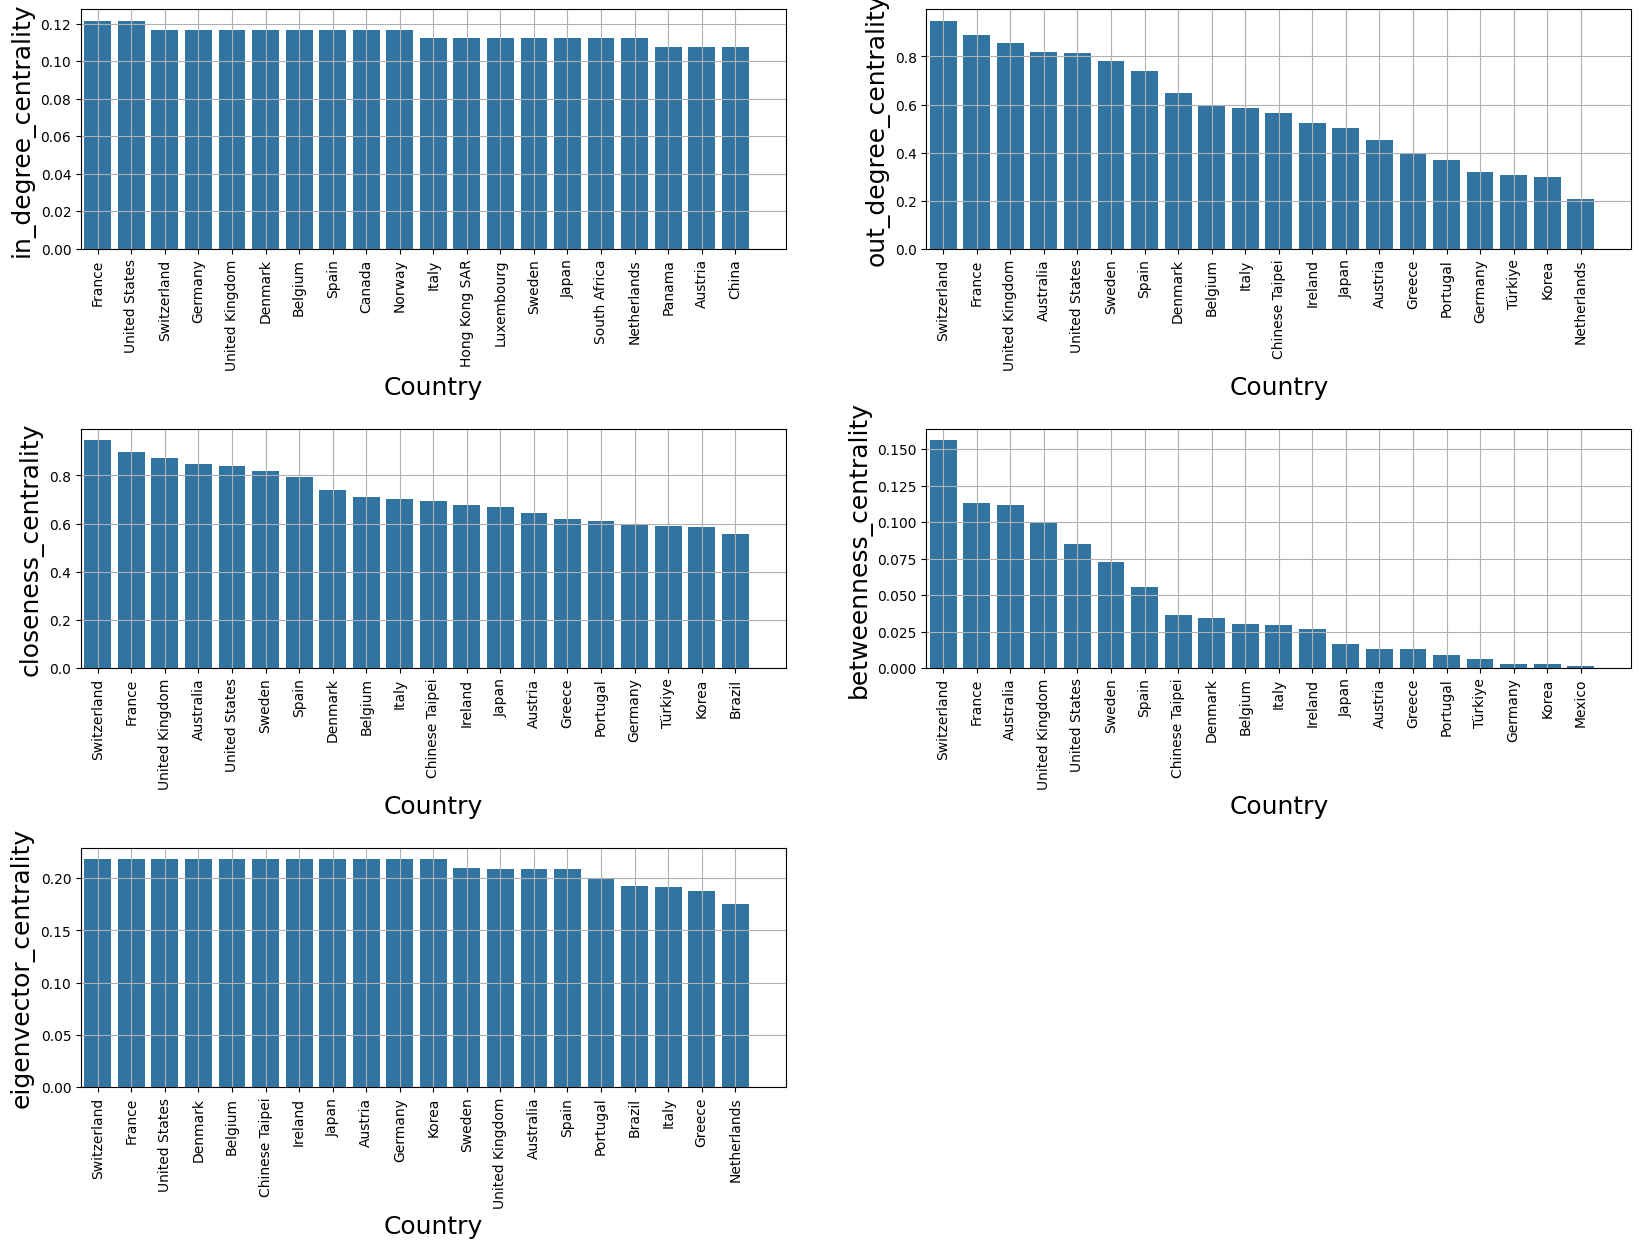

In [18]:
Centrality_names = df_centrality.columns.tolist()[1:]
kmax = 20  #show top kmax users


fig = plt.figure(figsize = (20,14))

for count,centrality_name in enumerate(Centrality_names):
    plt.subplot(3,2,count+1) #make a 2 x 3 subplot, plot in box cnt+1
    df_plot = df_centrality.sort_values(by=[centrality_name],ascending=False).head(n=kmax)  #sort dataframe by centrality value

    ax = sns.barplot(data=df_plot, x='country', y=centrality_name)
    plt.xlim([-.5,kmax+.5])  #set xlimits to only show top kmax users
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)  #rotate axis tick labels 90 degrees
    #plt.xticks(fontsize = 14)
    #plt.yticks(fontsize = 14)
    plt.ylabel(f"{centrality_name}",fontsize = 18)
    plt.xlabel('Country',fontsize = 18)
    plt.grid()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.75)

plt.show()

In [19]:
deg = dict(G.degree(weight='2013-Q4'))
deg = {k: v for k, v in sorted(deg.items(), key=lambda item: item[1], reverse=False)}

deg2 = dict(G2.degree(weight='2013-Q4'))
deg2 = {k: v for k, v in sorted(deg2.items(), key=lambda item: item[1], reverse=False)}
deg2

{'Panama': 93430.35500000001,
 'Greece': 117790.129,
 'Chile': 123148.378,
 'Portugal': 205633.2,
 'Türkiye': 220438.972,
 'Chinese Taipei': 262712.63899999997,
 'Austria': 289606.893,
 'Korea': 313989.528,
 'Mexico': 371630.92,
 'Brazil': 476873.78799999994,
 'Belgium': 477661.75800000003,
 'Denmark': 477829.009,
 'Ireland': 535960.972,
 'Sweden': 736121.696,
 'Australia': 759148.249,
 'Italy': 1144511.051,
 'Canada': 1232854.3969999999,
 'Netherlands': 1594188.0270000002,
 'Switzerland': 1735423.7969999998,
 'Spain': 1821684.346,
 'Japan': 2995991.211,
 'Germany': 3373919.6059999997,
 'France': 3382138.685,
 'United Kingdom': 5142528.721,
 'United States': 7510576.535}

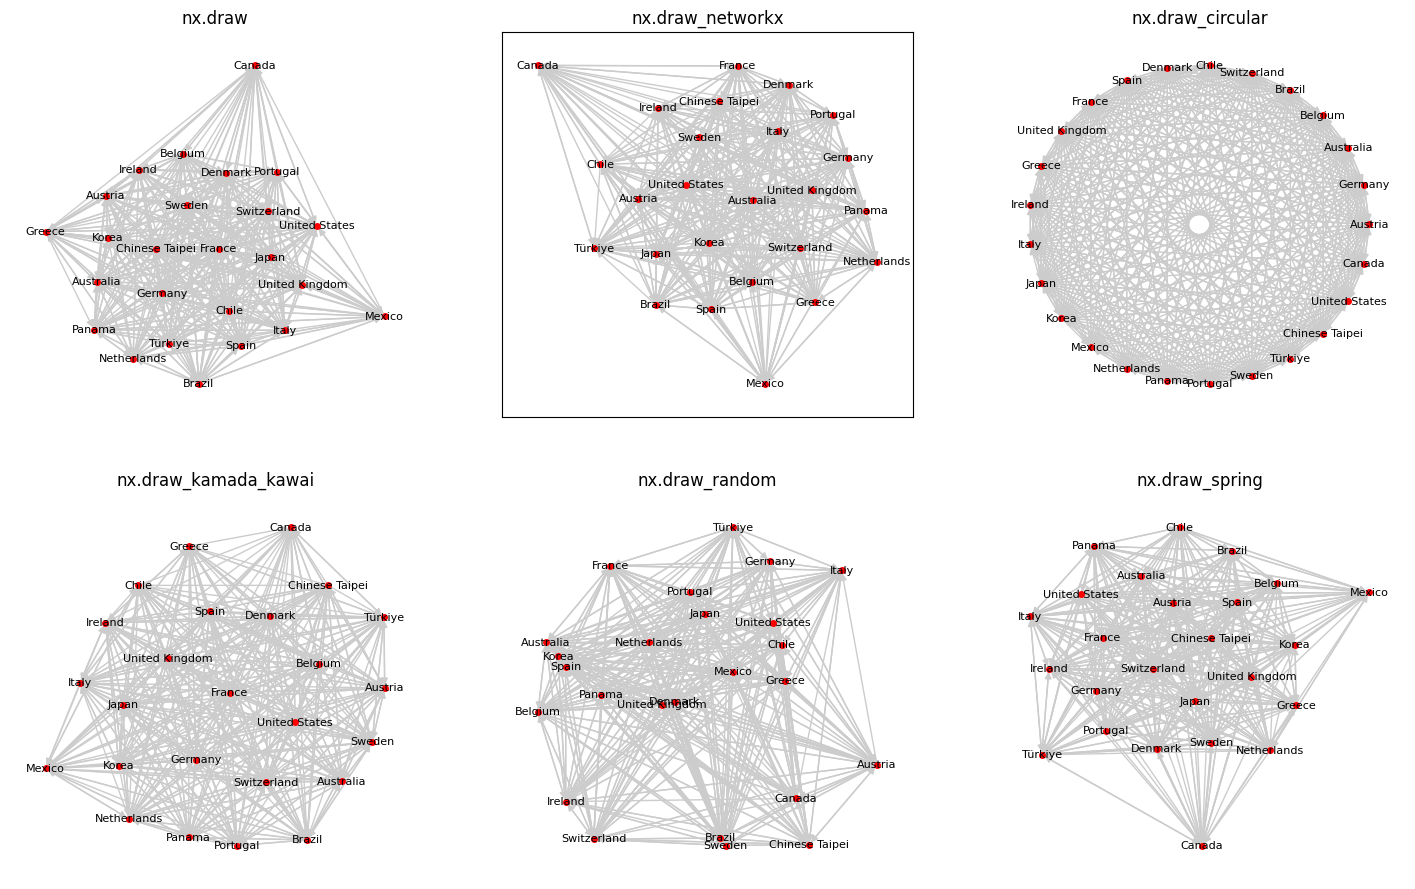

In [20]:
fig, axs = plt.subplots(2,3)
fig.set_figheight(11)
fig.set_figwidth(18)

axs[0,0].set_title('nx.draw')
nx.draw(G2, ax=axs[0,0], node_color="red", node_size=16, edge_color="#cccccc", width=1, font_size=8, with_labels=True)

axs[0,1].set_title('nx.draw_networkx')
nx.draw_networkx(G2, ax=axs[0,1], node_color="red", node_size=16, edge_color="#cccccc", width=1, font_size=8, with_labels=True)

axs[0,2].set_title('nx.draw_circular')
nx.draw_circular(G2, ax=axs[0,2], node_color="red", node_size=16, edge_color="#cccccc", width=1, font_size=8, with_labels=True)

axs[1,0].set_title('nx.draw_kamada_kawai')
nx.draw_kamada_kawai(G2, ax=axs[1,0], node_color="red", node_size=16, edge_color="#cccccc", width=1, font_size=8, with_labels=True)

axs[1,1].set_title('nx.draw_random')
nx.draw_random(G2, ax=axs[1,1], node_color="red", node_size=16, edge_color="#cccccc", width=1, font_size=8, with_labels=True)

axs[1,2].set_title('nx.draw_spring')
nx.draw_spring(G2, ax=axs[1,2], node_color="red", node_size=16, edge_color="#cccccc", width=1, font_size=8, with_labels=True)